# Solution 5
## Data Analysis
### FINM August Review 

Mark Hendricks

hendricks@uchicago.edu

TA: Maneet Singh

#### Data

- This homework uses the file, “sp500_returns.xlsx”.
- Find the data in the Github repo associated with the module, (link on Canvas.)

The data file contains...
- Return rates, $r^{GLD}_t$, for the GLD, (an ETF) which tracks the returns on gold.
- Return rates, $r^i_t$, for 451 single-name equities. These are all securities in the S&P 500 as of June 2022, filtered for names with sufficient return histories.

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

retsx = pd.read_excel('sp500_returns.xlsx', sheet_name=2, index_col=0)
gld = pd.read_excel('sp500_returns.xlsx', sheet_name=3, index_col=0)[['GLD']]

## 1. Penalized Regression

Consider a regression of GLD, denoted $r^{GLD}$, on all 451 returns of the S&P 500 stocks.
$$r^{GLD}_t = \alpha + \sum_{j=1}^k\beta^jr^j_t + \epsilon_t$$

1. **Estimate (1) with OLS**
        
    (a) Report the estimated intercept and betas

    (b) Report the R-squared

    (c) Which factors have the largest betas in explaining $r^{GLD}$?

    (d) Calculate $\beta^j\sigma^j$ for each regressor. Which of these is largest in magnitude, and thus most influential in explaining $r^{GLD}$?

    (e) Report the matrix condition number of $R'R$, where $R$ denotes the matrix of single-name equity return data. Why should this condition number give us pause about trusting the OLS estimates out-of-sample?

##### a)

In [3]:
# Estimate Betas with OLS
ols_model = LinearRegression().fit(retsx, gld)

# Display Betas
print('OLS Model Intercept: {:,.6f}'.format(ols_model.intercept_[0]))
print("")
print('OLS Model Betas:')
coef_ols = pd.DataFrame(ols_model.coef_.transpose(), index = retsx.columns, columns = ['Betas'])
display(coef_ols.style.format('{:,.4f}'))

OLS Model Intercept: 0.000613

OLS Model Betas:


,Betas
A,0.0647
AAP,-0.0301
AAPL,-0.0892
ABC,-0.0424
ABT,0.0752
ACN,-0.0223
ADBE,-0.0416
ADI,0.0255
ADM,-0.0061
ADP,0.0860


##### b)

In [4]:
# R-Squared
rsq = ols_model.score(retsx, gld)
print('In sample R-Squared: {:,.2%}'.format(rsq))

In sample R-Squared: 100.00%


##### c)

In [5]:
# Top 5 Factors with largest Beta

display(coef_ols.nlargest(5, columns='Betas'))

,Betas
NEM,0.159908
PM,0.134094
USB,0.132137
BR,0.123663
BAX,0.117452


##### d)

In [6]:
# Top 5 factors with largest Beta*sigma

sigma_beta_ols = retsx.std() * coef_ols['Betas']
display(sigma_beta_ols.nlargest(5))

NEM    0.007799
PHM    0.005463
SPG    0.005242
USB    0.005180
DRI    0.005144
dtype: float64

Scaling by $\sigma_j$ allows us to have a more useful comparison between regression coefficients. In doing so, we find the largest (in magnitude) of the coefficients, and thus the most influential regressor, is NEM. 

##### e)

In [7]:
np.linalg.cond(np.dot(retsx.transpose(), retsx))

8.842269813227102e+18

A large condition number should give us pause as it indicates that very small change in the inputs to our training data would yield very large changes in our model's fitted parameters. In the case of linear regression, a high condition number raises concerns about multicollinearity, which can easily distort both the interpretation of coefficients and their out-of-sample performance. The condition numbers produced here are extremely large.

2. **Estimate (1) with Ridge Regression. Use a penalty of 0.5 in the estimation.**
    
    (a) Report the R-squared.
    
    (b) Based on $\beta_j\sigma_j$, which factor is most influential for $r^{GLD}$?

In [8]:
model_Ridge = Ridge(alpha=0.5, fit_intercept=True).fit(retsx, gld)

# Display Betas
print('Ridge Model Intercept: {:,.6f}'.format(model_Ridge.alpha))
print("")
print('Ridge Model Betas:')
coef_ridge = pd.DataFrame(model_Ridge.coef_.transpose(), index = retsx.columns, columns = ['Beta'])
display(coef_ridge.style.format('{:,.4f}'))

Ridge Model Intercept: 0.500000

Ridge Model Betas:


,Beta
A,0.0130
AAP,-0.0130
AAPL,-0.0052
ABC,-0.0054
ABT,0.0017
ACN,-0.0052
ADBE,-0.0127
ADI,0.0001
ADM,0.0048
ADP,-0.0042


In [9]:
Ridge_rsq = model_Ridge.score(retsx, gld)
print('In sample R-Squared for Ridge Regression: {:,.2%}'.format(Ridge_rsq))

In sample R-Squared for Ridge Regression: 76.22%


In [10]:
sigma_beta_ridge = retsx.std() * coef_ridge['Beta']
display(sigma_beta_ridge.nlargest(5))

NEM     0.005137
FCX     0.002314
ENPH    0.002027
SLB     0.001125
CHTR    0.000895
dtype: float64

We find that NEM again seems to be most influential.

3. **Estimate (1) with LASSO Regression. Use a penalty of 2e-5 in the estimation.**
    
    (a) Report the estimated intercept and betas.
    
    (b) Report the R-squared.
    
    (c) Based on $\beta_j\sigma_j$, which factor is most influential for $r^{GLD}$?
    
    (d) How many regressors have a non-zero beta estimates?

In [11]:
model_Lasso = Lasso(alpha=2e-5, fit_intercept=True).fit(retsx, gld)

# Display Betas
print('Lasso Model Intercept: {:,.6f}'.format(model_Lasso.alpha))
print("")
print('Lasso Model Betas:')
coef_lasso = pd.DataFrame(model_Lasso.coef_.transpose(), index = retsx.columns, columns = ['Beta'])
display(coef_lasso.style.format('{:,.4f}'))

Lasso Model Intercept: 0.000020

Lasso Model Betas:


,Beta
A,0.0111
AAP,-0.0017
AAPL,-0.0000
ABC,-0.0016
ABT,0.0000
ACN,-0.0000
ADBE,-0.0000
ADI,-0.0000
ADM,0.0000
ADP,-0.0000


In [12]:
Lasso_rsq = model_Lasso.score(retsx, gld)
print('In sample R-Squared for Lasso Regression: {:,.2%}'.format(Lasso_rsq))

In sample R-Squared for Lasso Regression: 75.41%


In [13]:
sigma_beta_lasso = retsx.std() * coef_lasso['Beta']
display(sigma_beta_lasso.nlargest(5))

NEM     0.011329
O       0.002376
SLB     0.001808
ENPH    0.001698
PHM     0.001391
dtype: float64

NEM is the largest coefficient, and is significantly larger than even the second largest coefficient.

In [14]:
n_zeros = sum(abs(coef_lasso.Beta.values - 0) < 1e-100)
print('Number of Factors with Zero Beta: {}'.format(n_zeros))

Number of Factors with Zero Beta: 376


4. **How do the estimations compare across the three methods?**
    
    (a) Create a histogram of estimated betas across the three methods, (OLS, Ridge, LASSO.) Are they all nonzero? Are there positive and negative values? Do they range widely in magnitude?
    
    (b) Which has the largest R-squared? Is this a surprise?

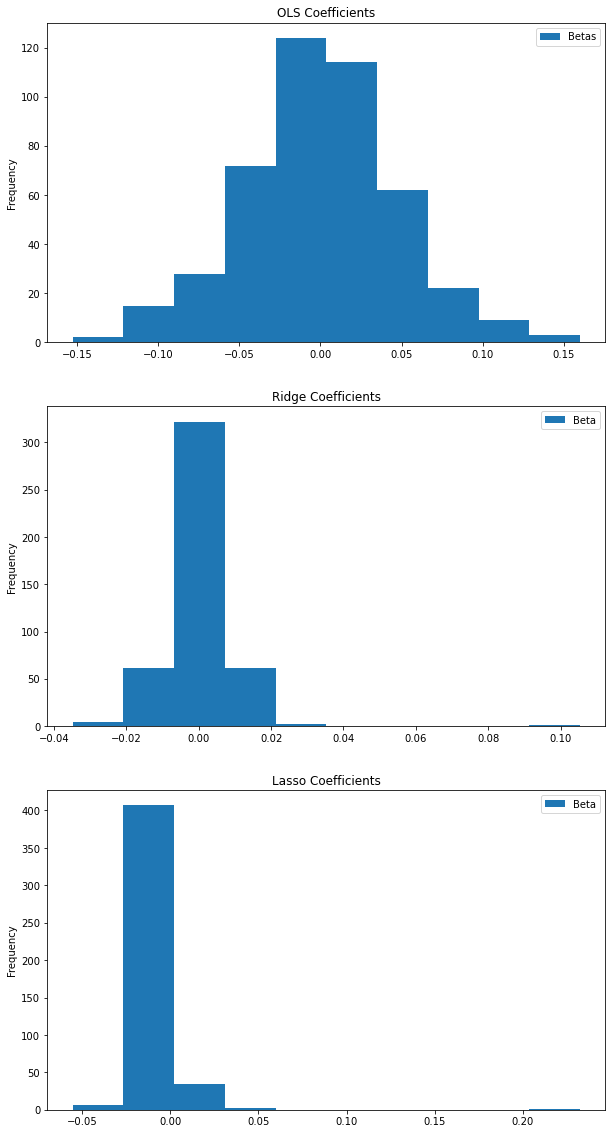

In [15]:
fig, ax = plt.subplots(3,1, figsize = (10,20))

coef_ols.plot(kind='hist', bins=10, title='OLS Coefficients', ax = ax[0])
coef_ridge.plot(kind='hist', bins=10, title='Ridge Coefficients', ax = ax[1])
coef_lasso.plot(kind='hist', bins=10, title='Lasso Coefficients', ax = ax[2])
plt.show()

Immediately, it is quite clear that the penalized regressions (Lasso and Ridge) have notably smaller coefficients in general. It is also clear that the penalized regressions tend to push many coefficients towards 0, but some get pushed away from 0. This reflects the notion that the penalties serve to give more "responsibility" to certain regressors.

Unsurprisingly, all 3 models had coefficients distributed near 0, with Lasso having a significant proportion of them being equal to 0.

From above, we found that OLS had the largest r-squared, which is entirely unsurprising given that this is referring to *in sample* performance. OLS was given far more "power" to fit the training data.

5. **Try using cross-validation (with K-folds) to estimate the penalty parameter for Ridge and LASSO. Estimate this CV using two functions from *sklearn.linear_model***
    - RidgeCV
    - LassoCV

   Feel free to use the default parameters, including the default number of folds. Report the CV penalty parameter for Lasso and Ridge.

In [16]:
model_ridge_cv = RidgeCV().fit(retsx, gld)

In [17]:
print('Ridge Regression Cross Validation Alpha: {}'.format(model_ridge_cv.alpha_))

Ridge Regression Cross Validation Alpha: 0.1


In [18]:
model_lasso_cv = LassoCV().fit(retsx, gld)

In [19]:
print('Lasso Regression Cross Validation Alpha: {:,.6f}'.format(model_lasso_cv.alpha_))

Lasso Regression Cross Validation Alpha: 0.000046


6. **Use your estimations based on data through 2020 to fit the model for 2021-2022.** 

    Use the CV penalty parameters (from the previous problem) for Ridge and Lasso. 
    
    What is the r-squared in these out-of-sample fits$^7$? 
    
    Which method does better out-of-sample?

In [20]:
train_X = retsx.loc[:'2020']
train_y = gld.loc[:'2020']

test_X = retsx.loc['2021':]
test_y = gld.loc['2021':]

In [21]:
ols_is = LinearRegression().fit(train_X, train_y)
ridge_is = Ridge(alpha=model_ridge_cv.alpha_).fit(train_X, train_y)
lasso_is = Lasso(alpha=model_lasso_cv.alpha_).fit(train_X, train_y)

In [22]:
# OOS R-Squared
oos_score_ols = ols_is.score(test_X, test_y)
oos_score_ridge = ridge_is.score(test_X, test_y)
oos_score_lasso = lasso_is.score(test_X, test_y)

print('Out-of-Sample R-Squared for OLS: {:,.2%}'.format(oos_score_ols))
print('Out-of-Sample R-Squared for Ridge: {:,.2%}'.format(oos_score_ridge))
print('Out-of-Sample R-Squared for Lasso: {:,.2%}'.format(oos_score_lasso))

Out-of-Sample R-Squared for OLS: -53.71%
Out-of-Sample R-Squared for Ridge: 32.41%
Out-of-Sample R-Squared for Lasso: 48.78%


As demonstrated by the out of sample r-squared values, OLS performs far worse than does penalized regression. In fact, both Lasso and Ridge perform far better than the null model. Given more penalty values in our cross-validation for Ridge (instead of the default scikit-learn parameters), we may be better able to compare Lasso and Ridge. In general, however, it is important to remember that the "optimal" penalties found in part 5 were calculated using the test sample, which gives rise to some lookahead bias.